# **Predictive Crime Mapping with a spatio-temporal kernel density estimation approach**

## **Case of study: Dallas City**

*Institute of Mathematical and Computational Engineering*

*School of Engineering*

*Pontifical Catholic University of Chile*

**Authors:** Christian Carstens, Mauro Mendoza, Francisco Tobar

**Date:** 2019-04-11

`Python version: 3.7`

### **DB Request**

In [2]:
import pandas as pd
from sodapy import Socrata

import credentials as cre

/Users/msmendozaelguera/Desktop/iPre/Modeling/venv/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


ModuleNotFoundError: No module named 'credentials'

In [145]:
with Socrata(cre.socrata_domain,
             cre.API_KEY_S,
             username=cre.USERNAME_S,
             password=cre.PASSWORD_S) as client:
    query = """
select
    incidentnum,
    geocoded_column,
    date1,
    time1,
    x_coordinate,
    y_cordinate
where
    geocoded_column is not null
    and date1 is not null
    and time1 is not null
    and x_coordinate is not null
    and y_cordinate is not null
limit
    3000
""" # 530000 max. 11/04

    results = client.get(cre.socrata_dataset_identifier, query=query, content_type='json')
    df = pd.DataFrame.from_records(results)

### **DB Cleaning & Formatting**

In [146]:
df.loc[:, 'x_coordinate'] = df['x_coordinate'].apply(lambda x: float(x))
df.loc[:, 'y_cordinate'] = df['y_cordinate'].apply(lambda x: float(x))

df = df[['x_coordinate', 'y_cordinate']]

df.rename(columns={'x_coordinate':'x', 'y_cordinate':'y'}, inplace=True)

### Plotting

In [ ]:
import pandas as pd # Dataframes
import numpy as np # Arreglos

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as mc 
import matplotlib.pyplot as plt  

from scipy.stats import  gaussian_kde

from mpl_toolkits import mplot3d

from sklearn.datasets.samples_generator import make_blobs

# %config InlineBackend.figure_format ='retina'

In [137]:
dallas = gpd.read_file('shp/STREETS.shp')
crs = dallas.crs
crs

{'init': 'epsg:2276'}

In [81]:
# Ploteo de las calles de Dallas en Dark mode, sin puntos.

# fig, ax = plt.subplots(figsize = (15, 15))
# ax.set_facecolor('xkcd:black')

# dallas.plot(ax = ax, alpha = .4, color="gray")

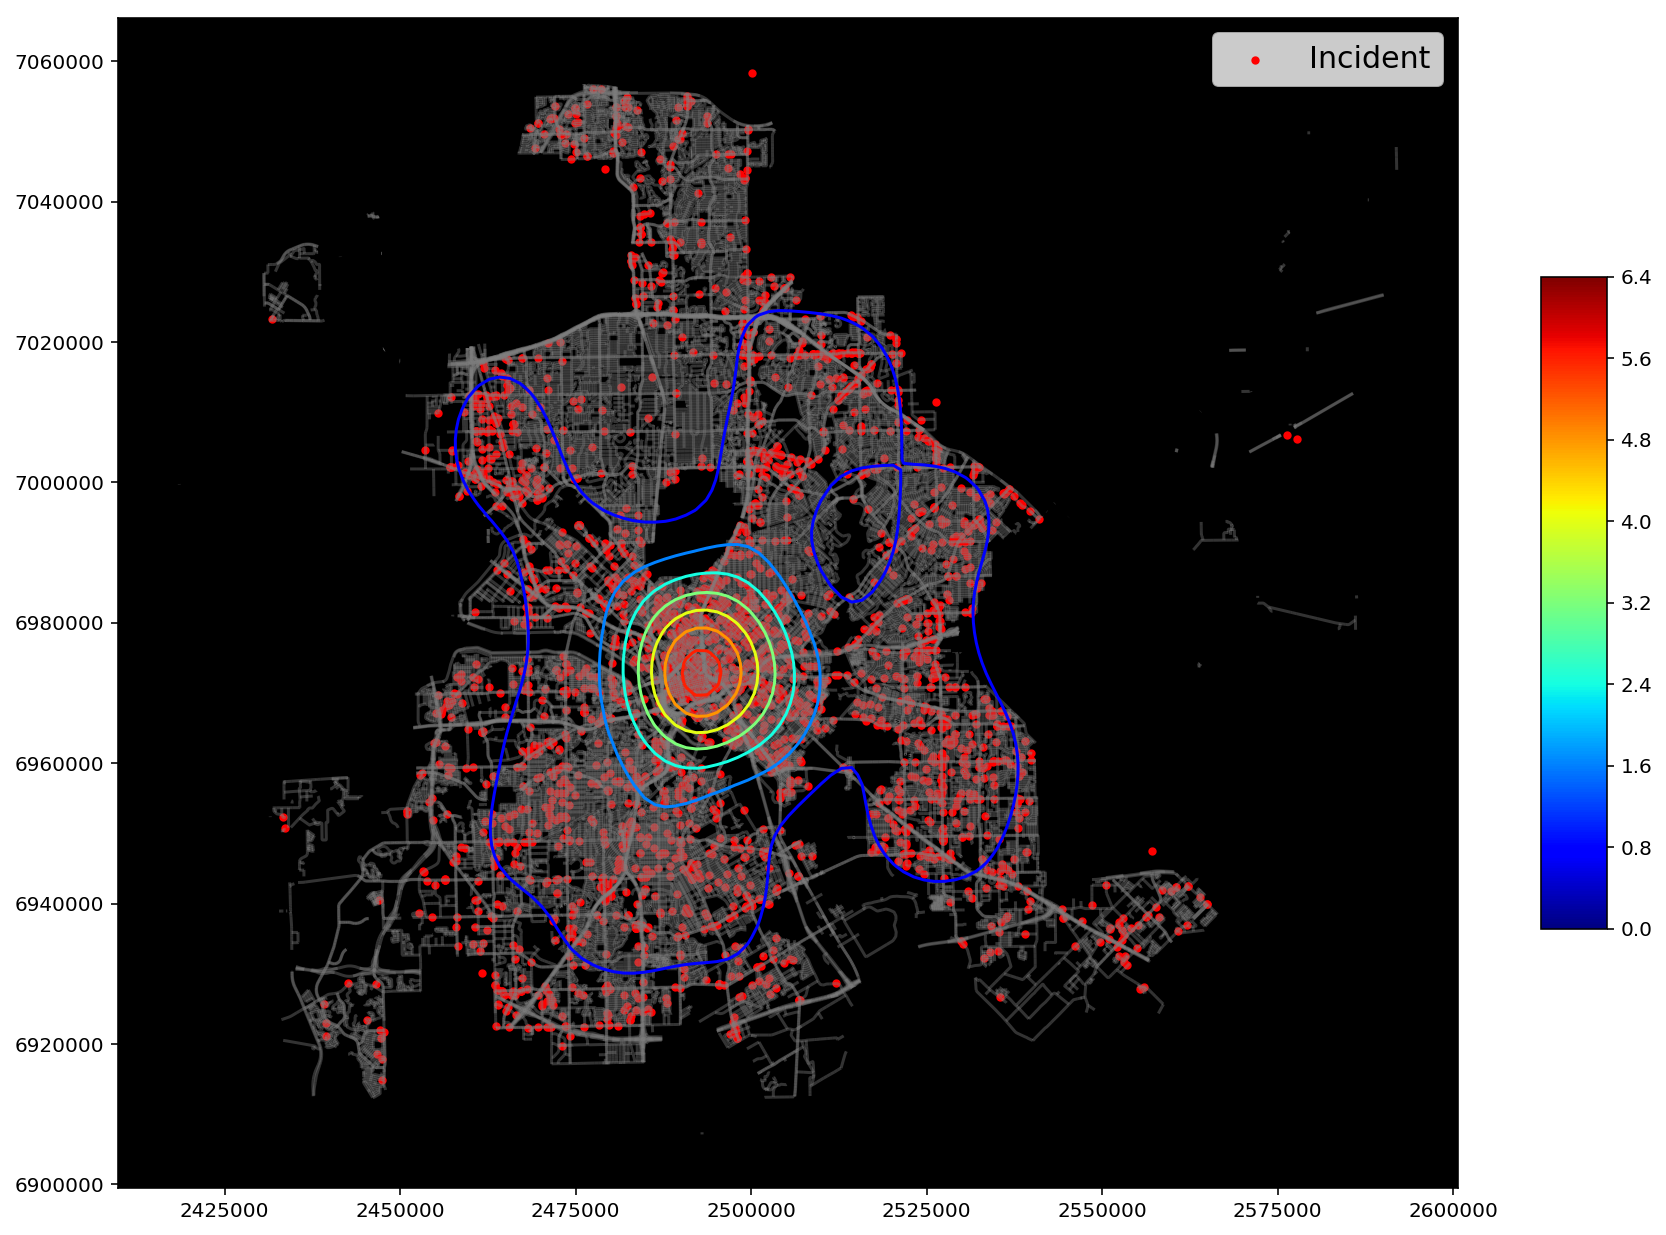

In [147]:
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
geo_df = gpd.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)

fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")
geo_df.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label = 'Incident')
plt.legend(prop={'size': 15})

nbins = 100
data = np.array(df[['x','y']])

x, y = data.T

k = gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zi_2 = zi * 3000 * (10 ** 6)/(.304)

# cs = plt.contour(xi, yi, zi.reshape(xi.shape), cmap = 'jet')
cs = plt.contour(xi, yi, zi_2.reshape(xi.shape), cmap = 'jet')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=cs.levels, shrink=.4, aspect=10)

plt.show()

# plt.savefig('figura.png') # Guardar el .png en el directorio

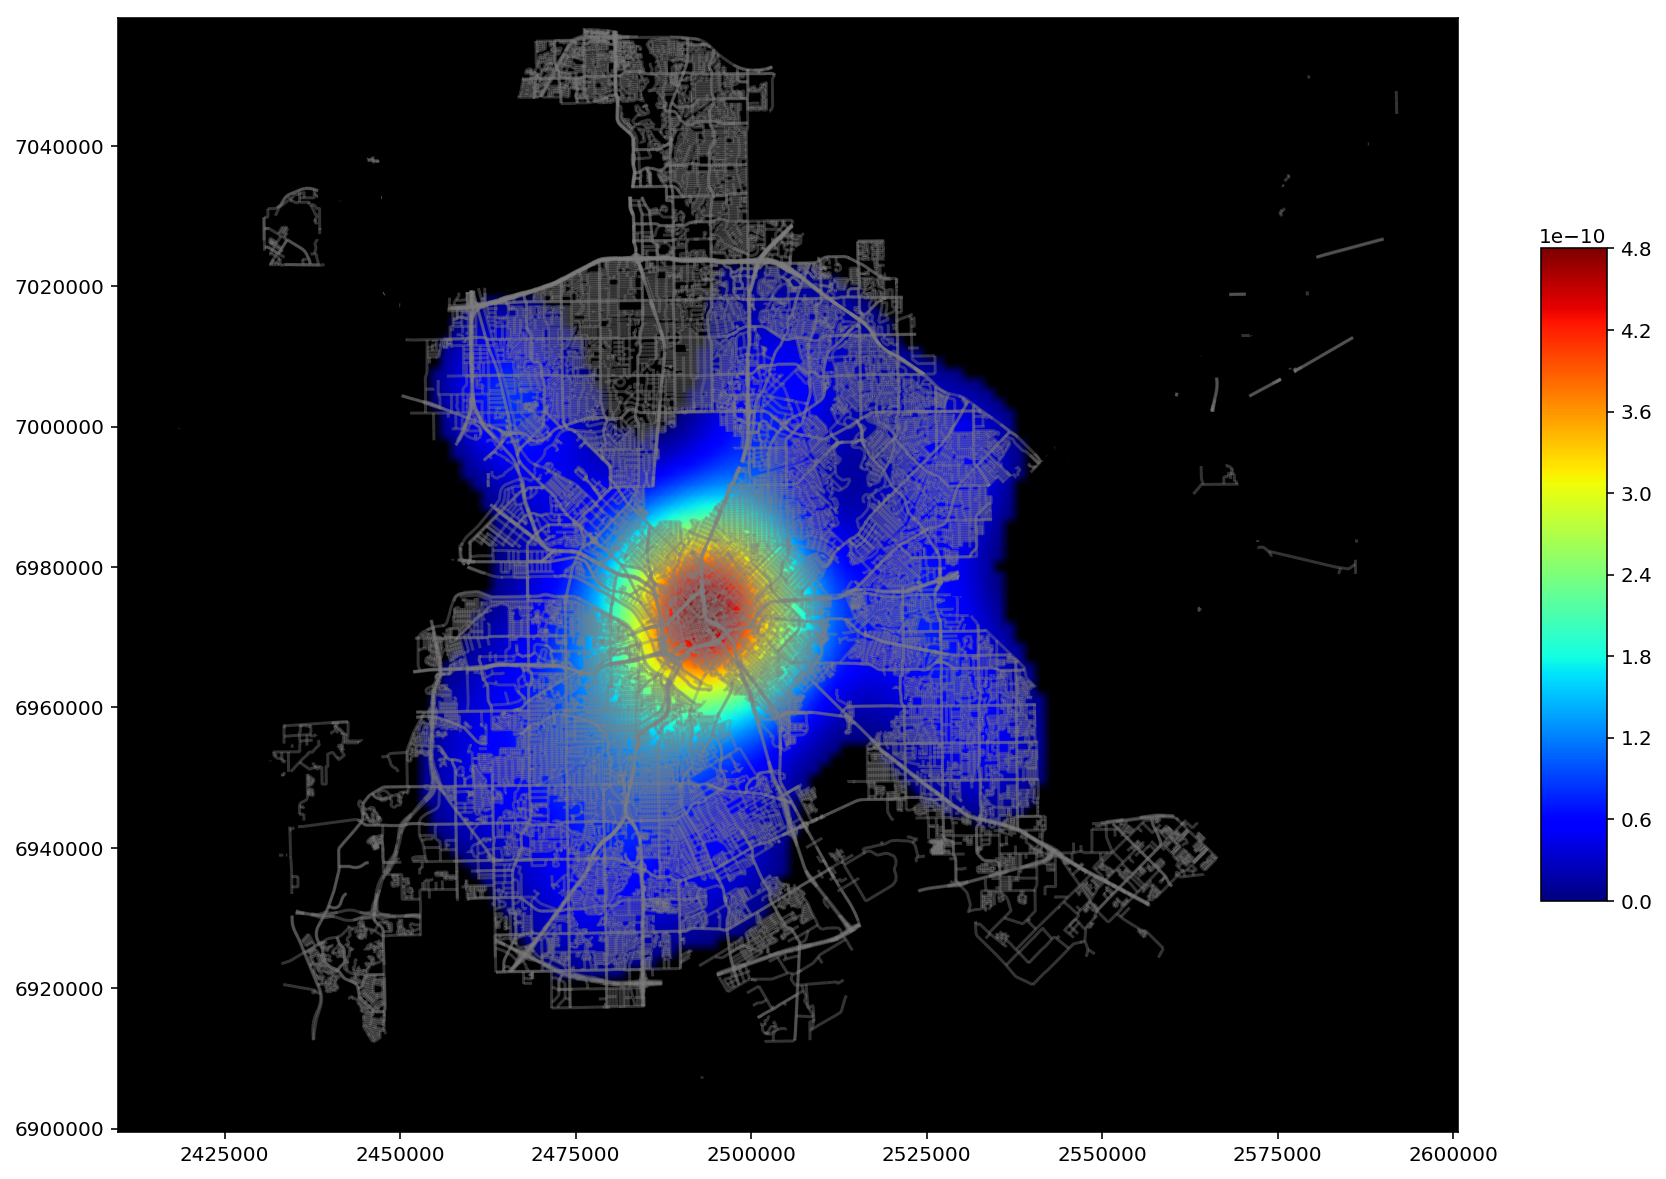

In [136]:
fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")

nbins = 100
data = np.array(df[['x','y']])

k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap2 = mpl.cm.get_cmap("jet")
cmap2.set_under("k")

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=cmap2, vmin=.6e-10)
fig.colorbar(sm, ticks=cs.levels, shrink=.4, aspect=10)

plt.show()

FigureCanvasNbAgg()

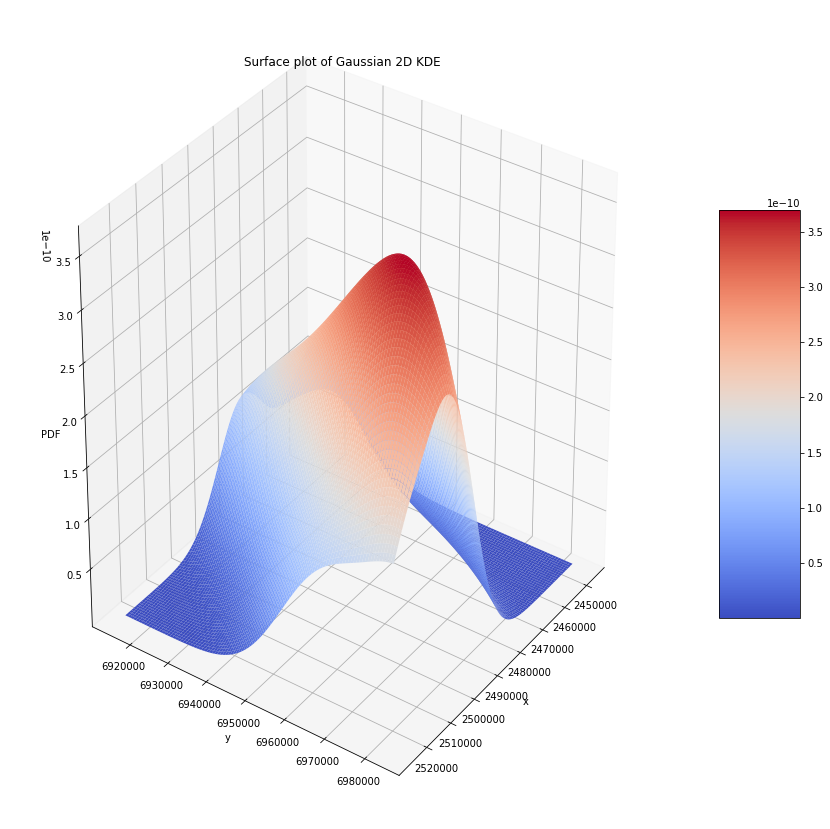

In [49]:
%matplotlib widget

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xi, yi,  zi.reshape(xi.shape), rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(30, 35)